# **Active Object Localization with Deep Reinforcement Learning**

In [20]:
!git clone https://github.com/SkalskiP/yolov9.git

Cloning into 'yolov9'...


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import sys
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml

from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox

%matplotlib inline

E:\Studies\Sem-8\REL301m\project\Object-Detection-Deep-Reinforcement-Learning\Dynamic\DQN_4layer_yolov9_backbone\yolov9\utils\general.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


**Prepare and loading images from dataset along with their bounding boxes:**

In [2]:
def load_data_from_csv(df_path, target_size=(224, 224)):
    final_image_list = []
    final_bbox_list = []

    df = pd.read_csv(df_path)
    len = df.shape[0]
    n_img = 0

    for _, row in df.iterrows():
        img_path = row['img_path']
        x_min = int(row['x_min'])
        x_max = int(row['x_max'])
        y_min = int(row['y_min'])
        y_max = int(row['y_max'])

        # read img
        img_path = img_path.replace('\\', '/')
        img_path = r'../' + img_path
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

        # get original size
        h_orig, w_orig, _ = image.shape

        # resize img
        image = cv2.resize(image, target_size)

        # scale bounding box coordinates
        x_scale = target_size[0] / w_orig
        y_scale = target_size[1] / h_orig

        x_min = int(x_min * x_scale)
        x_max = int(x_max * x_scale)
        y_min = int(y_min * y_scale)
        y_max = int(y_max * y_scale)

        final_image_list.append(image)
        final_bbox_list.append([x_min, y_min, x_max, y_max])
        n_img+=1
        print(f'{n_img}/{len}')

        #Convert to NumPy arrays after the loop finishes
    image_array = np.asarray(final_image_list, dtype=np.uint8)
    bbox_array = np.asarray(final_bbox_list)

    return image_array, bbox_array

**Load dataset**

In [5]:
dataset_csv_path = '../img_path_with_bbox.csv'
data = load_data_from_csv(df_path=dataset_csv_path, target_size=(640, 640))
image_list, bbox_list = data
print(f"Loaded {len(image_list)} images and {len(bbox_list)} bounding boxes")

1/1117
2/1117
3/1117
4/1117
5/1117
6/1117
7/1117
8/1117
9/1117
10/1117
11/1117
12/1117
13/1117
14/1117
15/1117
16/1117
17/1117
18/1117
19/1117
20/1117
21/1117
22/1117
23/1117
24/1117
25/1117
26/1117
27/1117
28/1117
29/1117
30/1117
31/1117
32/1117
33/1117
34/1117
35/1117
36/1117
37/1117
38/1117
39/1117
40/1117
41/1117
42/1117
43/1117
44/1117
45/1117
46/1117
47/1117
48/1117
49/1117
50/1117
51/1117
52/1117
53/1117
54/1117
55/1117
56/1117
57/1117
58/1117
59/1117
60/1117
61/1117
62/1117
63/1117
64/1117
65/1117
66/1117
67/1117
68/1117
69/1117
70/1117
71/1117
72/1117
73/1117
74/1117
75/1117
76/1117
77/1117
78/1117
79/1117
80/1117
81/1117
82/1117
83/1117
84/1117
85/1117
86/1117
87/1117
88/1117
89/1117
90/1117
91/1117
92/1117
93/1117
94/1117
95/1117
96/1117
97/1117
98/1117
99/1117
100/1117
101/1117
102/1117
103/1117
104/1117
105/1117
106/1117
107/1117
108/1117
109/1117
110/1117
111/1117
112/1117
113/1117
114/1117
115/1117
116/1117
117/1117
118/1117
119/1117
120/1117
121/1117
122/1117
123/1117
1

**Showing some pictures from 20 classes of dataset:**

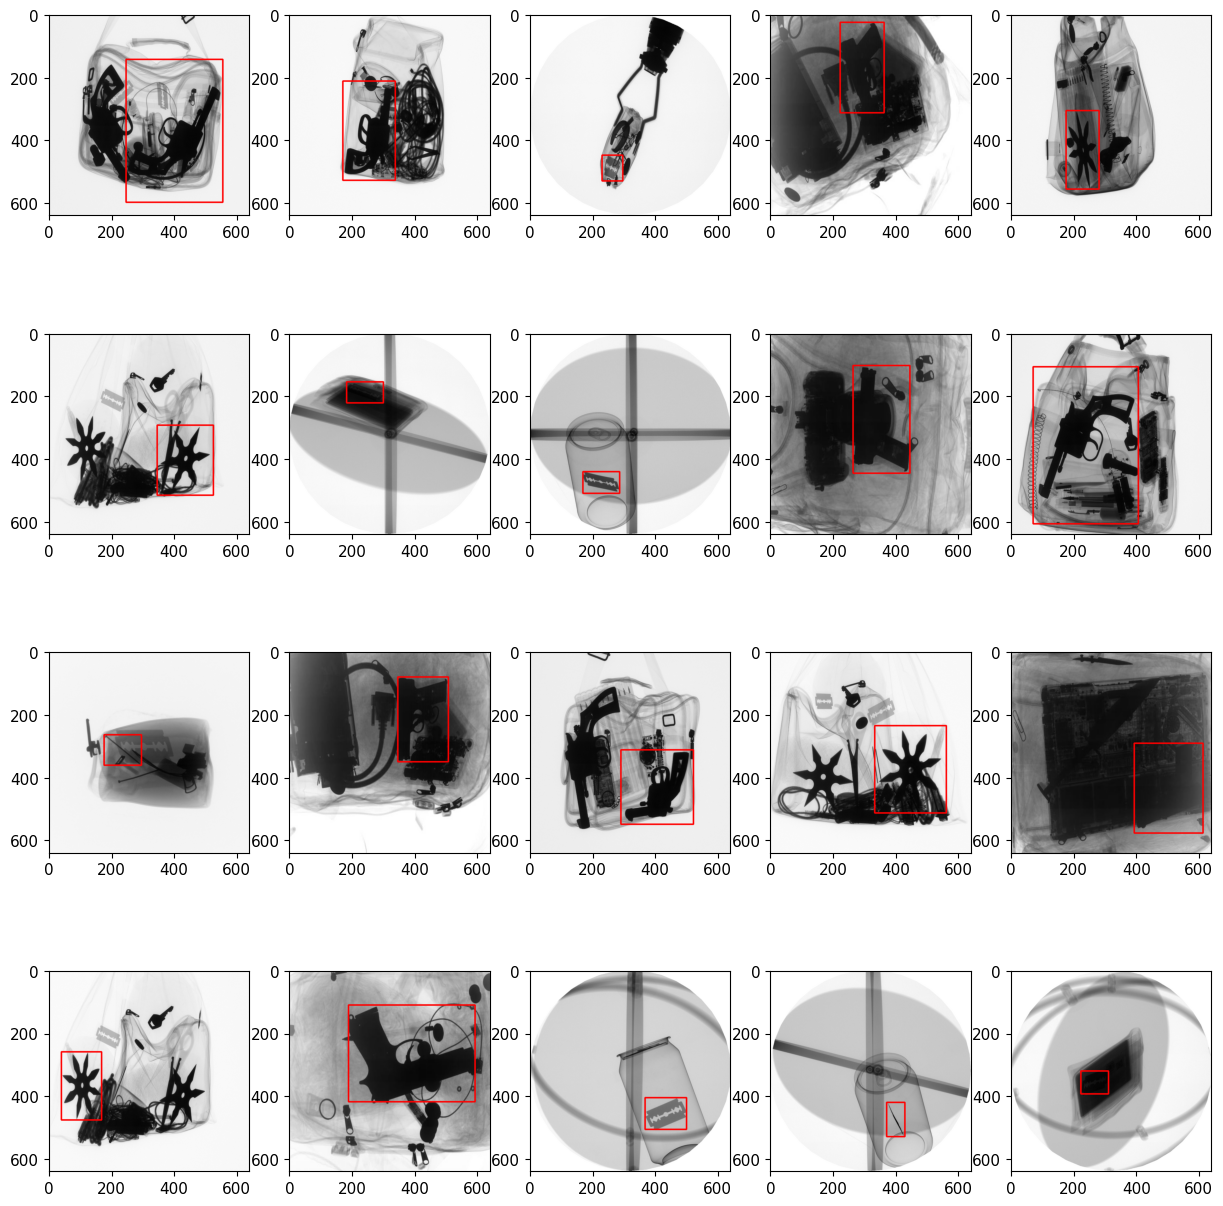

In [6]:
shuffled_indices = np.random.permutation(len(image_list))[:20]
shuffled_images = [image_list[i] for i in shuffled_indices]
shuffled_bboxes = [bbox_list[i] for i in shuffled_indices]

plt.figure(figsize=(15,20))
from_start, to_start = 0, 20
for i in range(from_start, to_start):
    plt.subplot(5,5,i-from_start+1)
    # im = image_list[i]
    # bbox = bbox_list[i]
    im = shuffled_images[i-from_start]
    bbox = shuffled_bboxes[i-from_start]
    # Draw a rectangle with blue line borders of thickness of 1 px
    mask = cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3])  , (255, 0, 0) , 3)
    masked_data = cv2.bitwise_and(im, im, mask)
    plt.imshow(masked_data)
plt.show()

**Train test split data**

In [7]:
from sklearn.model_selection import train_test_split

# First split: 80% for training, 20% for temporary (validation + test)
train_images, temp_images, train_bboxes, temp_bboxes = train_test_split(
    image_list, bbox_list, test_size=0.2, random_state=42
)

# Second split: Split the temporary set into validation and test sets (50% of temp -> 10% of total for each)
val_images, test_images, val_bboxes, test_bboxes = train_test_split(
    temp_images, temp_bboxes, test_size=0.5, random_state=42
)

print(f"Total images: {len(image_list)}")
print(f"Training set size: {len(train_images)} images")
print(f"Validation set size: {len(val_images)} images")
print(f"Testing set size: {len(test_images)} images")

Total images: 1117
Training set size: 893 images
Validation set size: 112 images
Testing set size: 112 images


**Training the agent:**
(to see the images of test results scroll down in the output box)

In [8]:
history_size = 1
# history_size = 5
action_option = 9
# max_steps = 20 # max steps
max_steps = 20 # max steps
experience_sample_size = 20 # batch size
max_experience_size = 1000 # replay buffer size
gamma = 0.9
# gamma = 0.1
loss_arr = []

# --- Epsilon-Greedy Strategy Parameters ---
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay_epochs = 80 # Number of epochs to decay epsilon over

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from collections import deque

# --- PyTorch Model Definition ---
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        # self.fc3 = nn.Linear(1024, output_size)
        # add another layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = self.fc3(x)

        # with additional layer
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def create_q_model():
    feature_size = 512  # YOLOv9 backbone feature size
    input_size = feature_size + action_option * history_size
    output_size = action_option
    return QNetwork(input_size, output_size)

def create_feature_extractor(finetune: bool = False):
    """Create a YOLOv9 backbone feature extractor pre-trained on GDXray."""
    config_path = r'yolov9/models/detect/gelan-c.yaml'
    weights_path = r'weights/best.pt'
    
    # Load config
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Create full model
    model = Model(config, ch=3, nc=4)
    
    # Load weights
    if weights_path and os.path.exists(weights_path):
        ckpt = torch.load(weights_path, map_location="cpu", weights_only=False)
        model.load_state_dict(ckpt["model"].float().state_dict(), strict=False)
        print(f"Loaded YOLOv9 weights from {weights_path}")
    
    # Extract backbone
    feature_extractor = nn.Sequential(*model.model[:9])
    
    if finetune:
        for param in feature_extractor.parameters():
            param.requires_grad = True
        feature_extractor.train()
    else:
        for param in feature_extractor.parameters():
            param.requires_grad = False
        feature_extractor.eval()
    
    return feature_extractor

# --- PyTorch Feature Extraction ---
def extract_feature(image, history, feature_model):
    # 1. History feature (one-hot encoding of action history)
    history_feature = np.zeros(action_option * history_size, dtype=np.float32)
    for i in range(history_size):
        action = history[i]
        if action != -1:
            history_feature[i * action_option + action] = 1.0

    # 2. Image feature (YOLOv9 preprocessing dùng letterbox 640x640, chuẩn hóa, CHW)
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.ndim == 3 and image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    img_rgb = image.copy()
    img_letterbox, _, _ = letterbox(
        img_rgb,
        new_shape=(640, 640),
        auto=False,
        scaleFill=False,
        scaleup=False
    )

    img_letterbox = img_letterbox.astype(np.float32) / 255.0
    img_letterbox = np.ascontiguousarray(img_letterbox.transpose(2, 0, 1))
    input_tensor = torch.from_numpy(img_letterbox).unsqueeze(0).to(device)
    
    requires_grad = feature_model.training and any(param.requires_grad for param in feature_model.parameters())
    with torch.set_grad_enabled(requires_grad):
        feats = feature_model(input_tensor)
    
    pool = nn.AdaptiveAvgPool2d((1, 1))
    feats = pool(feats)
    feats = feats.view(feats.size(0), -1)

    image_feature = feats.detach().cpu().numpy().flatten().astype(np.float32)

    feature = np.concatenate((image_feature, history_feature))
    return feature[np.newaxis, :]

def compute_q(feature, deep_q_model):
    feature_tensor = torch.from_numpy(feature).float().to(device)
    with torch.no_grad():
        output = deep_q_model(feature_tensor)
    return output.cpu().numpy().flatten()


def compute_mask(action, current_mask):
    image_rate = 0.1
    delta_width = image_rate * (current_mask[2] - current_mask[0])
    delta_height = image_rate * (current_mask[3] - current_mask[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if action == 0:
        dx1 = delta_width
        dx2 = delta_width
    elif action == 1:
        dx1 = -delta_width
        dx2 = -delta_width
    elif action == 2:
        dy1 = delta_height
        dy2 = delta_height
    elif action == 3:
        dy1 = -delta_height
        dy2 = -delta_height
    elif action == 4:
        dx1 = -delta_width
        dx2 = delta_width
        dy1 = -delta_height
        dy2 = delta_height
    elif action == 5:
        dx1 = delta_width
        dx2 = -delta_width
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 6:
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 7:
        dx1 = delta_width
        dx2 = -delta_width

    new_mask_tmp = np.array([current_mask[0] + dx1, current_mask[1] + dy1,
                         current_mask[2] + dx2, current_mask[3] + dy2])
    new_mask = np.array([
        min(new_mask_tmp[0], new_mask_tmp[2]),
        min(new_mask_tmp[1], new_mask_tmp[3]),
        max(new_mask_tmp[0], new_mask_tmp[2]),
        max(new_mask_tmp[1], new_mask_tmp[3])
    ])

    return new_mask


def compute_iou(mask, ground_truth):
    dx = min(mask[2], ground_truth[2]) - max(mask[0], ground_truth[0])
    dy = min(mask[3], ground_truth[3]) - max(mask[1], ground_truth[1])

    if (dx >= 0) and (dy >= 0):
        inter_area = dx * dy
    else:
        inter_area = 0

    mask_area = (mask[2] - mask[0]) * (mask[3] - mask[1])
    ground_truth_area = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    return inter_area / (mask_area + ground_truth_area - inter_area + 1e-8)


def compute_reward(action, ground_truth, current_mask):
    new_mask = compute_mask(action, current_mask)
    iou_new = compute_iou(new_mask, ground_truth)
    iou_current = compute_iou(current_mask, ground_truth)

    # area_current = (current_mask[2] - current_mask[0]) * (current_mask[3] - current_mask[1])
    # area_gt = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])
    # oversize = max(area_current - area_gt, 0.0)
    # penalty = 0.01 * oversize / (area_gt + 1e-8)  # scale so it stays small
    # reward = (iou_new - iou_current) * 10

    if iou_new > iou_current:
        reward = 1
    else:
        reward = -1

    return reward


def compute_end_reward(current_mask, ground_truth):
    current_iou = compute_iou(current_mask, ground_truth)
    # if current_iou > 0.5:
    #     return 10
    # elif current_iou > 0.2:
    #     return -5
    # else:
    #     return -2

    if current_iou > 0.5:
    # if current_iou > 0.7:
        return 3
    else:
        return -3


def select_action(ground_truth_box, step, q_value, epsilon, current_mask):
    if step == max_steps:
        action = 8
    else:
        if random.random() > epsilon:
            action = np.argmax(q_value)
        else:
            end_reward = compute_end_reward(current_mask, ground_truth_box)
            if end_reward > 0:
                action = 8
            else:
                rewards = []
                for i in range(action_option - 1):
                    reward = compute_reward(i, ground_truth_box, current_mask)
                    rewards.append(reward)
                rewards = np.asarray(rewards)
                positive_reward_index = np.where(rewards >= 0)[0]

                if len(positive_reward_index) == 0:
                    positive_reward_index = np.asarray(range(action_option))

                action = np.random.choice(positive_reward_index)

    return action


def execute_action(action, history, ground_truth_box, current_mask):
    if action == 8:
        new_mask = current_mask
        reward = compute_end_reward(current_mask, ground_truth_box)
        end = True
    else:
        new_mask = compute_mask(action, current_mask)
        reward = compute_reward(action, ground_truth_box, current_mask)
        history = history[1:]
        history.append(action)
        end = False

    return new_mask, reward, end, history


def compute_target(reward, new_feature, model):
    with torch.no_grad():
        q_values = model(torch.from_numpy(new_feature).float().to(device))
    return reward + gamma * torch.max(q_values).item()


def crop_image(image, new_mask):
    height, width, channel = np.shape(image)
    new_mask = np.asarray(new_mask).astype("int")
    new_mask[0] = max(new_mask[0], 0)
    new_mask[1] = max(new_mask[1], 0)
    new_mask[2] = min(new_mask[2], width)
    new_mask[3] = min(new_mask[3], height)
    cropped_image = image[new_mask[1]:new_mask[3], new_mask[0]:new_mask[2]]
    new_height, new_width, new_channel = np.shape(cropped_image)

    if new_height == 0 or new_width == 0:
        return np.zeros((512, 512, 3), dtype=np.uint8)
    else:
        return cropped_image


def experience_replay(policy_net, target_net, feature_model, experience, optimizer, loss_fn):
    if len(experience) < experience_sample_size:
        return

    sample = random.sample(experience, experience_sample_size)
    features, actions, new_features, rewards, ends = zip(*sample)

    feature_batch = torch.from_numpy(np.concatenate(features, axis=0)).float().to(device)
    action_batch = torch.tensor(actions, dtype=torch.int64).to(device)
    new_feature_batch = torch.from_numpy(np.concatenate(new_features, axis=0)).float().to(device)
    reward_batch = torch.tensor(rewards, dtype=torch.float32).to(device)
    end_batch = torch.tensor(ends, dtype=torch.float32).to(device)

    current_q_values = policy_net(feature_batch)
    current_q_values = current_q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_net(new_feature_batch).max(1)[0].detach()

    target_q_values = reward_batch + (1 - end_batch) * gamma * next_q_values

    loss = loss_fn(current_q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    params_to_clip = list(policy_net.parameters()) + [p for p in feature_model.parameters() if p.requires_grad]
    if params_to_clip:
        torch.nn.utils.clip_grad_norm_(params_to_clip, 1.0)
    optimizer.step()

    global loss_arr
    
    if os.path.exists(r'train_plot_yolov9') is False:
        os.makedirs(r'train_plot_yolov9')

    loss_csv_path = r"train_plot_yolov9/loss.csv"

    write_header = not os.path.exists(loss_csv_path) or os.path.getsize(loss_csv_path) == 0
    with open(loss_csv_path, 'a') as f:
        if write_header:
            f.write('loss\n')
        f.write(f"{loss.item()}\n")

    loss_arr.append(loss.item())
    if len(loss_arr) == 100:
        print("loss %s" % str(sum(loss_arr) / len(loss_arr)))
        loss_arr = []


# def validate_model(target_net, feature_model, val_images, val_bboxes):
#     """Evaluates the model on the validation set and returns the average IoU."""
#     print("--- Running Validation ---")

#     iou_scores = []

#     target_net.eval()
#     feature_model.eval()

#     with torch.no_grad():
#         for i in range(len(val_images)):
#             image = val_images[i]
#             ground_truth_box = val_bboxes[i]

#             history = [-1] * history_size
#             height, width, _ = image.shape
#             current_mask = np.asarray([0, 0, width, height])

#             end = False
#             step = 0

#             while not end:
#                 feature = extract_feature(image, history, feature_model)
#                 q_value = compute_q(feature, target_net)
#                 action = np.argmax(q_value)

#                 history = history[1:]
#                 history.append(action)

#                 if action == 8 or step == max_steps:
#                     end = True
#                 else:
#                     current_mask = compute_mask(action, current_mask)

#                 step += 1

#             final_iou = compute_iou(current_mask, ground_truth_box)
#             iou_scores.append(final_iou)

#     avg_iou = np.mean(iou_scores)
#     print(f"--- Validation Complete. Average IoU: {avg_iou:.4f} ---")

#     return avg_iou

def validate_model(val_images, val_bboxes):
    iou = []

    number_of_image = len(val_images)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/latest_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])
    
    # yolov9_backbone_path = r'weights\best.pt'
    # feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    # feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    print("--- Running Validation ---")

    for i in range(0, number_of_image):
        bounding_box = val_bboxes[i]
        image = val_images[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask
        iou.append(compute_iou(mask, bounding_box))

    avg_iou = sum(iou) / len(iou)
    print(f"--- Validation Complete. Average IoU: {avg_iou:.4f} ---")
    
    return avg_iou


def plot_loss_curve(df_iou_path=r"train_plot_yolov9/loss.csv"):
    df_loss = pd.read_csv(df_iou_path)
    plt.figure(figsize=(10, 5))

    # plot loss curve (have only 'loss' column)
    plt.plot(df_loss.index, df_loss['loss'], label='Training Loss', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.savefig(r'train_plot_yolov9/loss.png')
    plt.close()
    

def plot_iou_curve(df_iou_path=r"train_plot_yolov9/avg_iou.csv"):
    plt.figure(figsize=(10, 5))
    df_iou = pd.read_csv(df_iou_path)
    plt.plot(df_iou['epoch'], df_iou['avg_iou'], label='Validation Average IoU', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Average IoU')
    plt.title('Validation Average IoU Curve')
    plt.legend()
    plt.grid()
    plt.savefig(r'train_plot_yolov9/avg_iou.png')
    plt.close()


def train_deep_q(learning_rate, training_epoch, train_image_list, train_bounding_box_list, val_image_list, val_bboxes, feature_model):
    experience = deque(maxlen=max_experience_size)

    policy_net = create_q_model().to(device)
    target_net = create_q_model().to(device)

    params_to_update = list(policy_net.parameters()) + [p for p in feature_model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4, factor=0.7, min_lr=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    latest_model_path = r"weights_DQN_4layer_yolov9/latest_model.pth"

    start_epoch = 1
    best_val_iou = -1.0

    if os.path.exists(latest_model_path):
        print(f"Resuming training from {latest_model_path}")
        checkpoint = torch.load(latest_model_path, map_location=device)
        policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        # feature_key = 'feature_extractor_state_dict' if 'feature_extractor_state_dict' in checkpoint else 'vgg16_state_dict'
        # feature_model.load_state_dict(checkpoint[feature_key])
        if 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        if 'epoch' in checkpoint:
            start_epoch =  checkpoint['epoch'] + 1

    # feature_model_path = r'weights\best.pt'
    # if os.path.exists(feature_model_path):
    #     print(f"Loading feature extractor weights from {feature_model_path}")
    #     ckpt = torch.load(feature_model_path, map_location=device, weights_only=False)
    #     missing, unexpected = feature_model.load_state_dict(
    #         ckpt["model"].float().state_dict(), strict=False)
    #     print("Missing:", missing, "Unexpected:", unexpected)

    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    loss_fn = nn.SmoothL1Loss()

    epsilon_decay_value = (epsilon_start - epsilon_final) / epsilon_decay_epochs
    epsilon = epsilon_start

    iou_csv_path = r"train_plot_yolov9/avg_iou.csv"
    if os.path.exists(r"weights_DQN_4layer_yolov9/best_model.pth") and os.path.exists(iou_csv_path):
        try:
            avg_iou_df = pd.read_csv(iou_csv_path)
            if not avg_iou_df.empty and 'avg_iou' in avg_iou_df.columns:
                best_val_iou = avg_iou_df['avg_iou'].max()
        except (pd.errors.EmptyDataError, KeyError):
            best_val_iou = -1.0

    if start_epoch > 1:
        epsilon -= epsilon_decay_value * (start_epoch - 1)
        epsilon = max(epsilon_final, epsilon)
        print(f"Adjusted epsilon for resumed training: {epsilon:.4f}")

    os.makedirs('train_plot_yolov9', exist_ok=True)

    for current_epoch in range(start_epoch, start_epoch + training_epoch):
        print(f"Now starting epoch {current_epoch} with epsilon = {epsilon:.4f}")

        policy_net.train()
        # feature_model.train()

        indices = np.random.permutation(len(train_image_list))
        training_set_size = len(indices)

        for i, idx in enumerate(indices):
            image = train_image_list[idx]
            ground_truth_box = train_bounding_box_list[idx]
            history = [-1] * history_size
            height, width, channel = np.shape(image)
            current_mask = np.asarray([0, 0, width, height])
            feature = extract_feature(image, history, feature_model)
            end = False
            step = 0
            total_reward = 0

            while not end:
                q_value = compute_q(feature, policy_net)
                action = select_action(ground_truth_box, step, q_value, epsilon, current_mask)
                new_mask, reward, end, history = execute_action(action, history, ground_truth_box, current_mask)
                cropped_image = crop_image(image, new_mask)
                new_feature = extract_feature(cropped_image, history, feature_model)

                experience.append((feature, action, new_feature, reward, end))

                experience_replay(policy_net, target_net, feature_model, experience, optimizer, loss_fn)

                feature = new_feature
                current_mask = new_mask
                step += 1
                total_reward += reward

            if (i + 1) % 100 == 0:
                print(f"  Image {i+1}/{training_set_size}, total reward {total_reward}")

        os.makedirs('weights_DQN_4layer_yolov9', exist_ok=True)
        torch.save({
            'epoch': current_epoch,
            'policy_net_state_dict': policy_net.state_dict(),
            'feature_extractor_state_dict': feature_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, latest_model_path)

        print(f"--- End of Epoch {current_epoch}: Updating target network ---")
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

        val_iou = validate_model(val_image_list, val_bboxes)
        
        plot_loss_curve()

        # lr_before = optimizer.param_groups[0]['lr']
        # scheduler.step(val_iou)
        # lr_after = optimizer.param_groups[0]['lr']
        # if lr_after < lr_before:
        #     print(f"Epoch {current_epoch}: Learning rate reduced from {lr_before} to {lr_after}.")
        lr_before = optimizer.param_groups[0]['lr']
        scheduler.step()
        lr_after = optimizer.param_groups[0]['lr']
        print(f"Epoch {current_epoch}: Learning rate adjusted from {lr_before} to {lr_after}.")

        write_header = not os.path.exists(iou_csv_path) or os.path.getsize(iou_csv_path) == 0
        with open(iou_csv_path, 'a') as f:
            if write_header:
                f.write('epoch,avg_iou\n')
            f.write(f"{current_epoch},{val_iou}\n")

        plot_iou_curve()

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            print(f"New best validation IoU: {best_val_iou:.4f}. Saving best_model.pth")
            torch.save({
                'epoch': current_epoch,
                'policy_net_state_dict': policy_net.state_dict(),
                'feature_extractor_state_dict': feature_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, r"weights_DQN_4layer_yolov9/best_model.pth")

        if current_epoch < epsilon_decay_epochs:
            epsilon -= epsilon_decay_value
            epsilon = max(epsilon_final, epsilon)

    return policy_net, feature_model


def main():
    learning_rate = 1e-5
    training_epoch = 100

    feature_model = create_feature_extractor(finetune=False).to(device)

    trained_policy_net, trained_feature_model = train_deep_q(
        learning_rate,
        training_epoch,
        train_images,
        train_bboxes,
        val_images,
        val_bboxes,
        feature_model
    )

    os.makedirs('weights_DQN_4layer_yolov9', exist_ok=True)
    torch.save({
        'policy_net_state_dict': trained_policy_net.state_dict(),
        'feature_extractor_state_dict': trained_feature_model.state_dict(),
    }, r"weights_DQN_4layer_yolov9/final_model.pth")

Using device: cuda


In [ ]:
main()

**Testing the agent (best weight on val data) on test images and calculating the average iou:**

best model weights

In [9]:
# This function is largely for visualization and saving, can be adapted similarly to test2
def test(image_list, bounding_box_list):
    iou = []
    predicted_bbox_list = []

    number_of_image = len(image_list)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/best_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])
    
    # yolov9_backbone_path = r'weights\best.pt'
    # feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    # feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    for i in range(0, number_of_image):
        bounding_box = bounding_box_list[i]
        image = image_list[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                print(f"Image {i}: End of search.")
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask

        # Ensure mask is within image bounds
        mask[0] = max(mask[0], 0)
        mask[1] = max(mask[1], 0)
        mask[2] = min(mask[2], width)
        mask[3] = min(mask[3], height)

        iou.append(compute_iou(mask, bounding_box))
        predicted_bbox_list.append(mask)

    avg_iou = sum(iou) / len(iou)
    pd.DataFrame(iou).to_csv('output_iou_test_data.csv', header=False, index=False)
    
    return avg_iou, predicted_bbox_list

In [10]:
avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
print(f"Test Average IoU: {avg_iou}")

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
Image 0: End of search.
Image 1: End of search.
Image 2: End of search.
Image 3: End of search.
Image 4: End of search.
Image 5: End of search.
Image 6: End of search.
Image 7: End of search.
Image 8: End of search.
Image 9: End of search.
Image 10: End of search.
Image 11: End of search.
Image 12: End of search.
Image 13: End of search.
Image 14: End of search.
Image 15: End of search.
Image 16: End of search.
Image 17: End of search.
Image 18: End of search.
Image 19: End of search.
Image 20: End of search.
Image 21: End of search.
Image 22: End of search.
Image 23: End of search.
Image 24: End of search.
Image 25: End of search.
Image 26: End of search.
Image 27: End of search.
Image 28: End of search.
Image 29: End of search.
Image 30: End of search.
Image 31: End of search.
Image 32: End of search.
Image 33: End of search.
Image 34: End of search.
Image 35: End of search.
Image 36: End of search.
Image 37: End of search.
Image 38: End of 

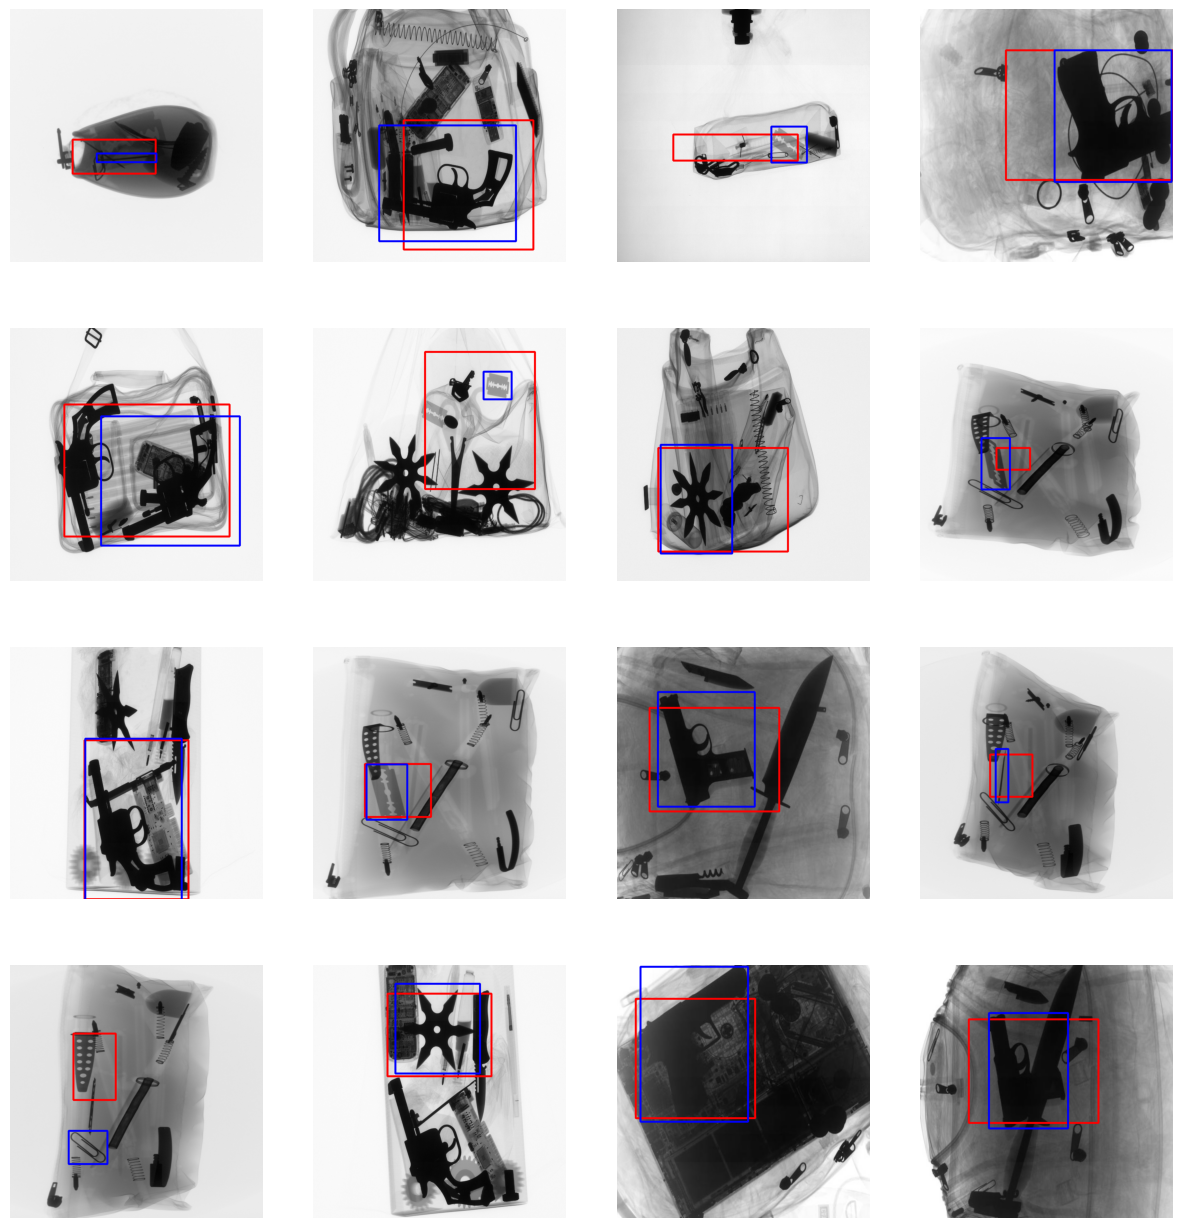

In [11]:
plt.figure(figsize=(15,20))

from_start = random.randint(0, len(test_images) - 16)
to_start = from_start + 16
for i in range(from_start, to_start):
    plt.subplot(5,4,i-from_start+1)
    
    # Make a copy of the image to draw on
    im_to_draw = test_images[i].copy()
    
    # --- Predicted BBox ---
    bbox = predicted_bbox_list[i]
    # Convert bbox coordinates to integers
    pt1 = (int(bbox[0]), int(bbox[1]))
    pt2 = (int(bbox[2]), int(bbox[3]))
    # Draw the predicted bounding box
    cv2.rectangle(im_to_draw, pt1, pt2, (255, 0, 0), 3) # red for predicted

    # --- Ground Truth BBox ---
    gt_bbox = test_bboxes[i]
    gt_pt1 = (int(gt_bbox[0]), int(gt_bbox[1]))
    gt_pt2 = (int(gt_bbox[2]), int(gt_bbox[3]))
    # Draw the ground truth bounding box
    cv2.rectangle(im_to_draw, gt_pt1, gt_pt2, (0, 0, 255), 3) # blue for ground truth
    
    plt.imshow(im_to_draw)
    # plt.title(f'Img {i}: Red=Pred, Blue=GT')
    plt.axis('off') # Hide axes
plt.show()
# plt.savefig('detect/test_results_yolov9.png')

**Testing the agent (last weight) on test images and calculating the average iou:**

last model weights

In [8]:
# This function is largely for visualization and saving, can be adapted similarly to test2
def test(image_list, bounding_box_list):
    iou = []
    predicted_bbox_list = []

    number_of_image = len(image_list)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_model = create_feature_extractor(finetune=False).to(device)
    deep_q = create_q_model().to(device)

    deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9/latest_model.pth", map_location=device)
    deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])

    yolov9_backbone_path = r'weights\best.pt'
    feature_state_dict = torch.load(yolov9_backbone_path, map_location=device, weights_only=False)
    feature_model.load_state_dict(feature_state_dict, strict=False)

    deep_q.eval()
    feature_model.eval()

    for i in range(0, number_of_image):
        bounding_box = bounding_box_list[i]
        image = image_list[i].copy()
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, feature_model)
        
        end = False
        masks = []
        step = 0

        while not end:
            q_value = compute_q(feature, deep_q)
            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == max_steps:
                end = True
                print(f"Image {i}: End of search.")
                new_mask = current_mask
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, feature_model)
            
            masks.append(new_mask)
            current_mask = new_mask
            step += 1

        mask = masks[-1] if masks else current_mask
        iou.append(compute_iou(mask, bounding_box))
        predicted_bbox_list.append(mask)

    avg_iou = sum(iou) / len(iou)
    pd.DataFrame(iou).to_csv('output_iou_test_data.csv', header=False, index=False)
    
    return avg_iou, predicted_bbox_list

In [9]:
# avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
avg_iou, predicted_bbox_list = test(test_images, test_bboxes)
print(f"Test Average IoU: {avg_iou}")

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt
Image 0: End of search.
Image 1: End of search.
Image 2: End of search.
Image 3: End of search.
Image 4: End of search.
Image 5: End of search.
Image 6: End of search.
Image 7: End of search.
Image 8: End of search.
Image 9: End of search.
Image 10: End of search.
Image 11: End of search.
Image 12: End of search.
Image 13: End of search.
Image 14: End of search.
Image 15: End of search.
Image 16: End of search.
Image 17: End of search.
Image 18: End of search.
Image 19: End of search.
Image 20: End of search.
Image 21: End of search.
Image 22: End of search.
Image 23: End of search.
Image 24: End of search.
Image 25: End of search.
Image 26: End of search.
Image 27: End of search.
Image 28: End of search.
Image 29: End of search.
Image 30: End of search.
Image 31: End of search.
Image 32: End of search.
Image 33: End of search.
Image 34: End of search.
Image 35: End of search.
Image 36: End of search.
Image 37: End of search.
Image 38: End of 

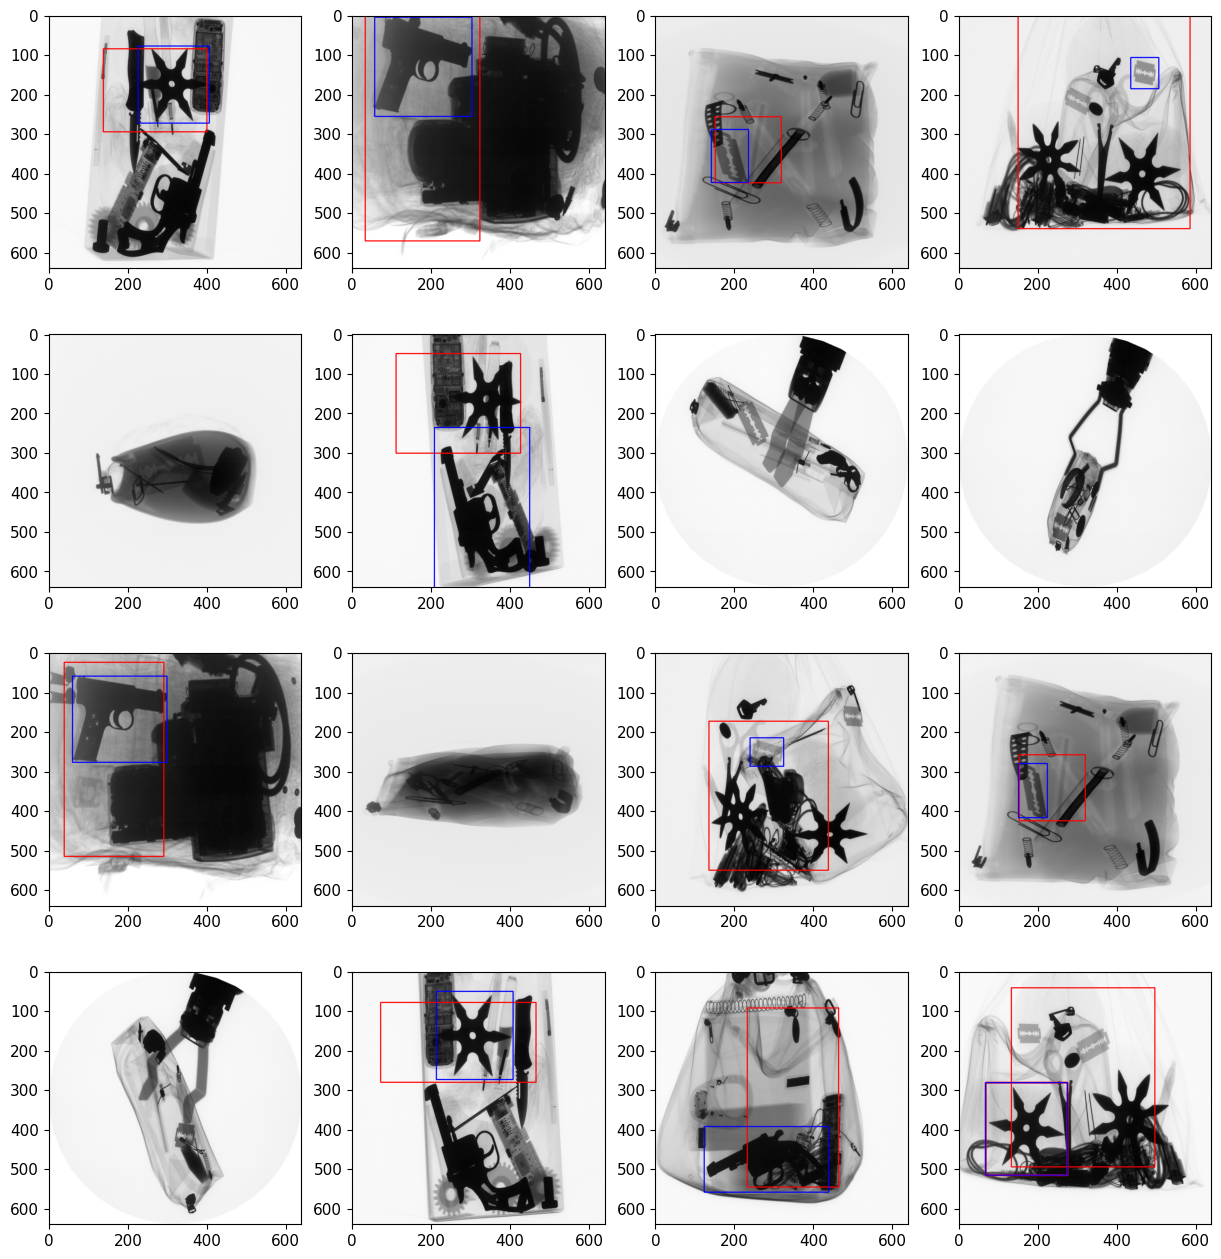

In [49]:
plt.figure(figsize=(15,20))

from_start = random.randint(0, len(test_images) - 16)
to_start = from_start + 16
for i in range(from_start, to_start):
    plt.subplot(5,4,i-from_start+1)\
    
    # Make a copy of the image to draw on
    im_to_draw = test_images[i].copy()
    
    # --- Predicted BBox ---
    bbox = predicted_bbox_list[i]
    # Convert bbox coordinates to integers
    pt1 = (int(bbox[0]), int(bbox[1]))
    pt2 = (int(bbox[2]), int(bbox[3]))
    # Draw the predicted bounding box
    cv2.rectangle(im_to_draw, pt1, pt2, (255, 0, 0), 2) # red for predicted

    # --- Ground Truth BBox ---
    gt_bbox = test_bboxes[i]
    gt_pt1 = (int(gt_bbox[0]), int(gt_bbox[1]))
    gt_pt2 = (int(gt_bbox[2]), int(gt_bbox[3]))
    # Draw the ground truth bounding box
    cv2.rectangle(im_to_draw, gt_pt1, gt_pt2, (0, 0, 255), 2) # blue for ground truth
    
    plt.imshow(im_to_draw)
    # plt.title(f'Img {i}: Red=Pred, Blue=GT')
    # plt.axis('off') # Hide axes
plt.show()
# plt.savefig('detect/test_results_yolov9.png')

Text(0, 0.5, 'Average IoU')

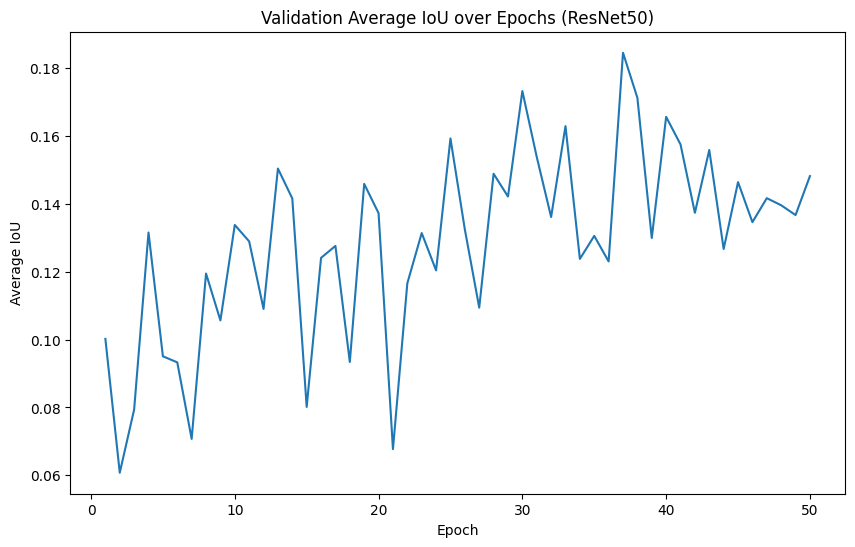

In [ ]:
# validation plot
avg_iou_df = pd.read_csv(r'train_plot_yolov9/avg_iou.csv')
plt.figure(figsize=(10, 6))
plt.plot(avg_iou_df['epoch'], avg_iou_df['avg_iou'])
plt.title('Validation Average IoU over Epochs (YOLOv9)')
plt.xlabel('Epoch')
plt.ylabel('Average IoU')

Text(0, 0.5, 'Loss')

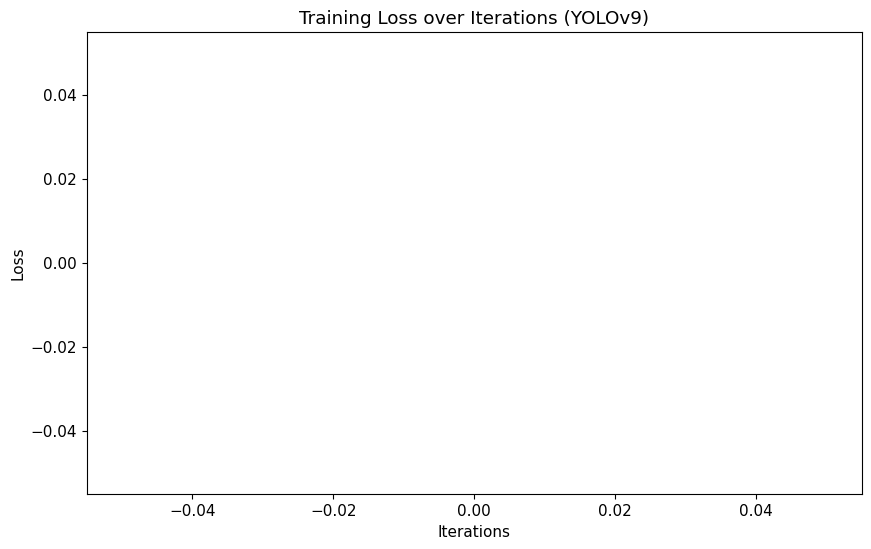

In [9]:
# loss plot
plt.figure(figsize=(10, 6))
plt.plot(loss_arr)
plt.title('Training Loss over Iterations (YOLOv9)')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [31]:
def classify_bbox(image, bbox, threshold=0.5):
    """
    Classify a cropped bounding box using YOLOv9 to check if it contains dangerous objects.
    
    Args:
        image: Original image (numpy array).
        bbox: Bounding box [x_min, y_min, x_max, y_max].
        threshold: Confidence threshold for classification.
    
    Returns:
        bool: True if bbox contains dangerous object (confidence > threshold), False otherwise.
    """
    from yolov9.utils.general import non_max_suppression  # Import here to ensure availability
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load full YOLOv9 model for classification
    config_path = r'yolov9/models/detect/gelan-c.yaml'
    weights_path = r'weights/best.pt'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    full_model = Model(config, ch=3, nc=4)
    ckpt = torch.load(weights_path, map_location=device, weights_only=False)
    full_model.load_state_dict(ckpt["model"].float().state_dict(), strict=False)
    full_model.to(device).eval()
    
    # Crop image by bbox
    cropped = crop_image(image, bbox)
    if cropped.shape[0] == 0 or cropped.shape[1] == 0:
        return False  # Invalid crop
    
    # Preprocess cropped image
    img_rgb = cropped.copy()
    img_letterbox, _, _ = letterbox(img_rgb, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=False)
    img_letterbox = img_letterbox.astype(np.float32) / 255.0
    img_letterbox = np.ascontiguousarray(img_letterbox.transpose(2, 0, 1))
    input_tensor = torch.from_numpy(img_letterbox).unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        pred = full_model(input_tensor)[0]
        pred = non_max_suppression(pred, conf_thres=0.1, iou_thres=0.45)
    
    # Check for dangerous classes (assuming classes 0-3 are dangerous)
    dangerous_classes = [0, 1, 2, 3]
    max_conf = 0.0
    for det in pred[0]:
        if int(det[5]) in dangerous_classes:
            max_conf = max(max_conf, det[4].item())
    
    return max_conf > threshold